In [18]:
import os
import os.path as op
from pathlib import Path
import numpy as np
from collections import defaultdict
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
import mne

from scipy import stats
from mne.stats import permutation_cluster_1samp_test, spatio_temporal_cluster_1samp_test, spatio_temporal_cluster_test

from library import helpers, config

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# define dict used for plotting of different epo parts:
plt_dict = defaultdict(dict)
stimon_ = {'t_stimon':  0,
      'xmin': -0.2,
      'xmax': 2.3}
plt_dict['stimon'] = stimon_
fulllength_ = {'t_stimon':  0.8,
      'xmin': -0.2,
      'xmax': 3.3}
plt_dict['fulllength'] = fulllength_

In [106]:
def get_evokeds_dict_cda(epo_part, sub_list):
    evokeds = defaultdict(list)
    for sub in sub_list:  # [3, 7, 22]:
        subID = 'VME_S%02d' % sub
        print(f'Loading {subID}.')
        fname = op.join(config.paths['03_preproc-pooled'], epo_part, 'difference',
                        f'{subID}-{epo_part}-difference-epo.fif')
        epos = mne.read_epochs(fname, verbose=False)
        epos.crop(plt_dict[epo_part]['xmin'], plt_dict[epo_part]['xmax'])
        event_dict = helpers.get_event_dict(epos.event_id)
        for load in ['LoadLow', 'LoadHigh']:
            evoked_load = epos[event_dict[load]].copy().average()   
            evokeds[load].append(evoked_load)
            for ecc in ['EccS', 'EccM', 'EccL']:
                if load == 'LoadLow':  # we don't want to do this twice
                    evoked_ecc = epos[event_dict[ecc]].copy().average()  
                    evokeds[ecc].append(evoked_ecc)
                # Interaction:
                evoked_interac = epos[event_dict[load]][event_dict[ecc]].copy()
                evoked_interac = evoked_interac.average()
                evokeds[load+ecc].append(evoked_interac)
        evokeds['all'].append(epos.copy().average())
    return(evokeds)


def plot_main_cda(ax, evokeds, picks=['P3', 'P5', 'PO3', 'PO7', 'O1']):
    # Plot main curve CDA:
    label_dict = dict()
    label_dict['CDA: Contra - Ipsi'] = evokeds['all']

    res = mne.viz.plot_compare_evokeds(label_dict, 
                                       picks=picks,
                                combine='mean', 
                                #colors = {k: config.colors[k] for k in plt_dict.keys()},
                                vlines=[0, 0.2, 2.2],
                                ci=True,
                                ylim=dict(eeg=[-1.5,1.5]),
                                title=None, 
                                axes = ax, 
                                show = False, 
                                truncate_yaxis=False, 
                                truncate_xaxis=False
                                )

    ax.legend(loc='upper right', prop={'size': 9})
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    ax.set(aspect=1.0/ax.get_data_ratio()*0.25, adjustable='box')
    ax.set_title('')
    ax.xaxis.label.set_size(9)
    ax.yaxis.label.set_size(9)
    plt.xticks(fontsize=9)


def run_cbp_test(data):
    # number of permutations to run
    n_permutations = 1000 
    # set initial threshold
    p_initial = 0.05
    # set family-wise p-value
    p_thresh = 0.05
    connectivity = None
    tail = 0.  # for two sided test

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = permutation_cluster_1samp_test(
        data, threshold=threshold, n_jobs=config.n_jobs, verbose=True, tail=tail,
        step_down_p=0.05, adjacency=connectivity,
        n_permutations=n_permutations, seed=42)

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return(T_obs, clusters, cluster_p_values)


def find_largest_cluster_times(clusters, times): 
    cl_lengths = [len(c[0]) for c in clusters]
    idx_max_length = np.argmax(cl_lengths)
    return (times[clusters[idx_max_length]], idx_max_length)



def plot_cbp_result_cda(ax, T_obs, clusters, cluster_p_values, p_thresh, times_full):
    y_max = np.max(np.abs(T_obs)) * np.array([-1.1, 1.1])
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] < p_thresh:
            h1 = ax.axvspan(times[c[0]], times[c[-1] - 1],
                            color='r', alpha=0.3)
    hf = ax.plot(times, T_obs, 'g')
    ax.hlines(0, times_full[0], times_full[-1])
    ax.legend((h1,), (u'p < %s' % p_thresh,), loc='upper right', ncol=1, prop={'size': 9})
    ax.set(xlabel="Time (s)", ylabel="T-values",
            ylim=y_max, xlim=times_full[np.array([0,-1])])
    #fig.tight_layout(pad=0.5)
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    ax.vlines([0,0.2,2.2], *y_max, linestyles='--', colors='k',
                    linewidth=1., zorder=1)
    ax.set_title('')
    ax.set(aspect=1.0/ax.get_data_ratio()*0.25, adjustable='box')
    ax.xaxis.label.set_size(9)
    ax.yaxis.label.set_size(9)


def write_mean_cda_amplitude_per_trial(epo_part, sub_list, cluster_times):
    df_all_sub = pd.DataFrame()
    for sub_nr in sub_list: 
        subID = 'VME_S%02d' % sub_nr
        fname = op.join(config.path_epos_sorted, epo_part, 'difference', subID + '-epo.fif')
        epos = mne.read_epochs(fname, verbose=False)
        # pick only CDA channels:
        epos.pick_channels(config.chans_CDA_dict['Left'])
        epos.crop(*cluster_times[np.array([0,-1])])
        event_dict = helpers.get_event_dict(epos.event_id)
        # grab data and average over channels and timepoints:
        cda_data = epos.copy()._data
        mean_amp_cda = cda_data.mean(axis=2).mean(axis=1)
        # Put to DF:
        data_total = pd.DataFrame(columns=['subID', 'c_StimN', 'c_Ecc', 'cda_mean_amp', 'trial_num'])
        for load in ['LoadLow', 'LoadHigh']: 
                for ecc in ['EccS', 'EccM', 'EccL']:
                    epos_cond = epos[event_dict[load]][event_dict[ecc]]
                    # Grab trial numbers (correct for collapsing):
                    trial_nums = [tn-720 if tn>=720 else tn for tn in epos_cond.selection]
                    # correct for zero indexing:
                    trial_nums = [t+1 for t in trial_nums]
                    # Grab CDA data:
                    cda_data = epos_cond.copy()._data
                    # Average over channels and timepoints:
                    mean_amp_cda = cda_data.mean(axis=2).mean(axis=1)
                    # collect data for this cond:
                    data_cond = pd.DataFrame({'subID': np.repeat(subID, len(mean_amp_cda)), 
                           'c_StimN': np.repeat(load, len(mean_amp_cda)),
                           'c_Ecc': np.repeat(ecc, len(mean_amp_cda)),
                           'cda_mean_amp':  mean_amp_cda, 
                           'trial_num': trial_nums})
                    # Bind it to global df:
                    data_total = data_total.append(data_cond)
        # Write subject data to disk:
        fpath = op.join(config.path_evokeds_summaries, 'CDA', epo_part)
        helpers.chkmk_dir(fpath)
        fname = op.join(fpath, subID + '-mean_amp_CDA.csv')
        data_total.to_csv(fname, index=False)
        df_all_sub = df_all_sub.append(data_total)
    # Write subject data to disk:
    fpath = op.join(config.path_evokeds_summaries, 'CDA', epo_part, 'global_summary')
    helpers.chkmk_dir(fpath)
    fname = op.join(fpath, 'allsubjects-mean_amp_CDA.csv')
    df_all_sub.to_csv(fname, index=False)
                 

In [58]:
sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)

epo_part = 'stimon'  #in ['stimon']:

# get the evokeds: 
evokeds = get_evokeds_dict_cda(epo_part, sub_list)

Loading VME_S01.
Loading VME_S02.
Loading VME_S03.
Loading VME_S04.
Loading VME_S05.
Loading VME_S06.
Loading VME_S07.
Loading VME_S08.
Loading VME_S09.
Loading VME_S10.
Loading VME_S15.
Loading VME_S16.
Loading VME_S17.
Loading VME_S18.
Loading VME_S20.
Loading VME_S21.
Loading VME_S23.
Loading VME_S24.
Loading VME_S25.
Loading VME_S26.
Loading VME_S27.


combining channels using "mean"


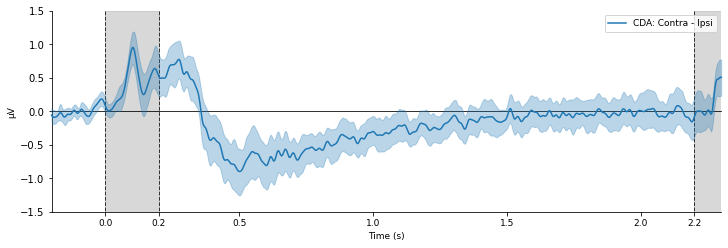

In [76]:
%matplotlib inline
# Plot main CDA wave:
plt.figure(figsize=(12,4)) #subplots(1,1,figsize=(12,4))
ax = plt.axes()
plot_main_cda(ax, evokeds, config.chans_CDA_dict['Left'])

In [ ]:
# Save it: 
fpath = op.join(config.path_plots, 'CDA', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'CDA_overall.png')
plt.savefig(fname)

In [78]:
###############################################################################
## Run cb-perm test to find intervall of interest:

# get data - cropped to retention interval:
times_full = evokeds['all'][0].times
c_list = [evo.copy().crop(0.2, 2.2).pick_channels(config.chans_CDA_dict['Left']) for evo in evokeds['all']]
data = np.array([np.mean(c.data, axis=0) for c in c_list])
times = c_list[0].times
p_thresh = 0.05
# run cbp test:
T_obs, clusters, cluster_p_values = run_cbp_test(data)
# get times of strongest cluster:
cluster_times, _ = find_largest_cluster_times(clusters, times)

combining channels using "mean"


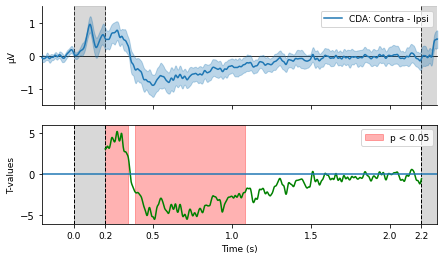

In [107]:
# Plot the result:
fig, axes = plt.subplots(2,figsize=(24,4), sharex=True)
ax = axes[0]
plot_main_cda(ax, evokeds, picks=config.chans_CDA_dict['Left'])
ax.xaxis.label.set_visible(False)
ax = axes[1]
plot_cbp_result_cda(ax, T_obs, clusters, cluster_p_values, p_thresh, times_full)

In [ ]:
# Save it: 
fpath = op.join(config.path_plots, 'CDA', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'CDA_overall_cbp_result.png')
fig.savefig(fname, bbox_inches="tight")


###################################################################################################
## Write out CDA data: 

# relevant times: cluster_times
# get index into full time vector: 
idx_cluster = np.isin(evokeds['all'][0].times, cluster_times)

# A: Mean amplitudes:

def write_mean_amp_to_file(ID):
    #conds = ['LoadHighEccS', 'LoadHighEccM', 'LoadHighEccL', 'LoadLowEccS', 'LoadLowEccM', 'LoadLowEccL']
    #data = [str(mean_amplitues_dict[key] * 1000) for key in conds]
    file_mean_amp = op.join(config.path_evokeds_summaries, ID + '_mean_amp_CDA.csv')
    with open(file_mean_amp, 'w') as ffile:
        for load in ['LoadHigh', 'LoadLow']:
            for ecc in ['EccS', 'EccM', 'EccL']:
                data_txt = ";".join([ID, load, ecc, format(mean_amplitues_dict[load+ecc], '.8f')])
                ffile.write(data_txt + "\n")



    # store mean amplitudes:
    mean_amplitues_dict = dict()

    for cond in evoked_dict.keys():
        dat = evoked_dict[cond]._data
        tms_idx = np.where((0.400 < evoked_dict[cond].times) & (evoked_dict[cond].times < 1.45))
        mean_amplitues_dict[cond] = np.mean(np.mean(evoked_dict[cond]._data, 0)[tms_idx])

combining channels using "mean"
combining channels using "mean"


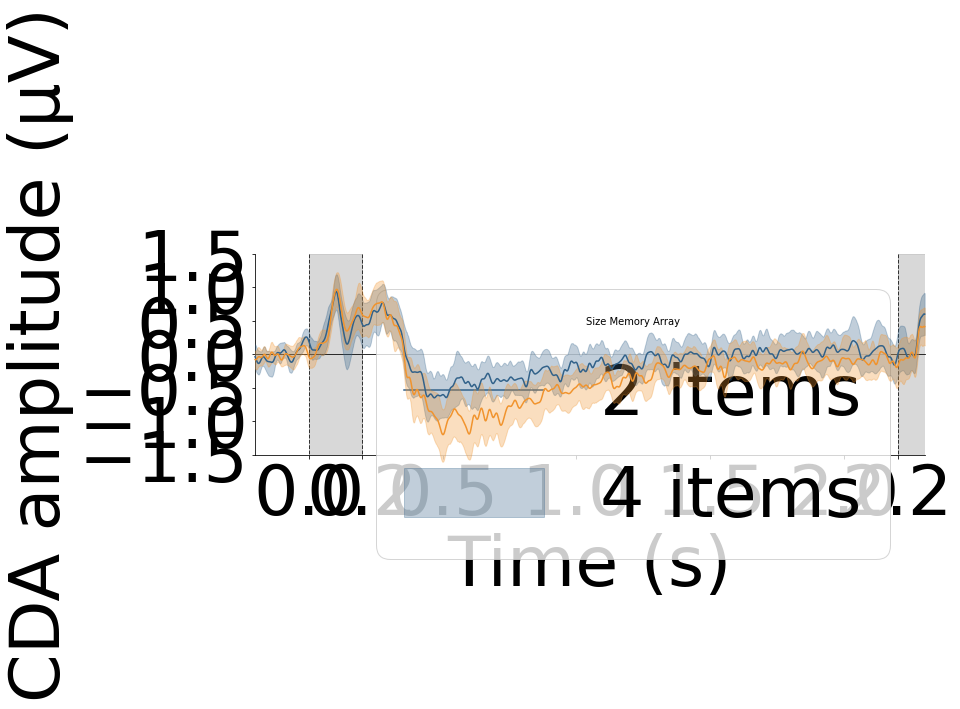

In [52]:
###################################################################################################
def plot_main_effect_load(ax):
    # Main effect Load:
    conds = ['LoadLow', 'LoadHigh']
    plt_names = ['2', '4']
    plt_dict = {nn: evokeds[k] for k, nn in zip(conds, plt_names)}
    res = mne.viz.plot_compare_evokeds(plt_dict, 
                                combine='mean', 
                                colors = {k: config.colors[k] for k in plt_dict.keys()},
                                vlines=[0, 0.2, 2.2],
                                ci=True,
                                ylim=dict(eeg=[-1.5,1.5]),
                                title=None, 
                                axes = ax, 
                                show = False, 
                                truncate_yaxis=False, 
                                truncate_xaxis=False
                                )
    ax.legend(loc=1, prop={'size': config.plt_label_size},
              title='Size Memory Array',
              labels=['2 items', '4 items'])
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    # ax.vlines([0,0.2,2.2], *[-1.5,1.5], linestyles='--', colors='k',
    #             linewidth=1., zorder=1)
    ax.set_aspect(0.25)
    ax.set_title('')
    ax.set_ylabel('CDA amplitude (' + chr(956) + 'V)')
    ax.xaxis.label.set_size(config.plt_label_size)
    ax.yaxis.label.set_size(config.plt_label_size)
    plt.xticks(fontsize=config.plt_label_size)
    plt.yticks(fontsize=config.plt_label_size)


# Plot main eefect load:
fig, ax = plt.subplots(1,1,figsize=(12,4))
#  ax = plt.axes()

plot_main_effect_load(ax)
#plt.show()

In [ ]:
# Save it: 
fpath = op.join(config.path_plots, 'CDA', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'mainEff_load.svg')
fig.savefig(fname, bbox_inches="tight")
################################################################
# Main effect load:

def plot_main_effect_ecc(ax):
    # Main Effect Ecc:
    conds = ['EccS', 'EccM', 'EccL']
    plt_names = ['4°', '9°', '14°']
    plt_dict = {nn: evokeds[k] for k, nn in zip(conds, plt_names)}
    res = mne.viz.plot_compare_evokeds(plt_dict, 
                                combine='mean', 
                                colors = {k: config.colors[k] for k in plt_dict.keys()},
                                vlines=[0, 0.2, 2.2],
                                ci=True,
                                ylim=dict(eeg=[-1.5,1.5]),
                                title=None, 
                                axes = ax, 
                                show = False, 
                                truncate_yaxis=False, 
                                truncate_xaxis=False
                                )
    ax.legend(loc=1, prop={'size': config.plt_label_size}, 
              title='Eccentricity', ncol=3)
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    # ax.vlines([0,0.2,2.2], *[-1.5,1.5], linestyles='--', colors='k',
    #             linewidth=1., zorder=1)
    ax.set_aspect(0.25)
    ax.set_title('')
    ax.set_ylabel('CDA amplitude (' + chr(956) + 'V)')
    ax.xaxis.label.set_size(config.plt_label_size)
    ax.yaxis.label.set_size(config.plt_label_size)
    plt.xticks(fontsize=config.plt_label_size)
    plt.yticks(fontsize=config.plt_label_size)

# plot main effect ecc: 
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax = plt.axes()

plot_main_effect_ecc(ax)
fig.show()
plt.show()

# Save it: 
fpath = op.join(config.path_plots, 'CDA', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'mainEff_ecc.svg')
fig.savefig(fname, bbox_inches="tight")



def plot_interaction_eff(axs):
    for ecc, tt, idx, leg in zip(['EccS', 'EccM', 'EccL'], 
                            ['Ecc = 4°', 'Ecc = 9°', 'Ecc = 14°'], 
                            [0, 1, 2], 
                            [1, False, False]):
        conds = ['LoadLow', 'LoadHigh']
        plt_names = ['Load Low', 'Load High']
        #data = [evo.crop(plt_dict[epo_part][xmin], plt_dict[epo_part][xmin]) for evo in evokeds]
        plt_dict = {nn: evokeds[k + ecc] for k, nn in zip(conds, plt_names)}
        res = mne.viz.plot_compare_evokeds(plt_dict, 
                                    combine='mean', 
                                    ci=True,
                                    axes=axs[idx],
                                    legend=leg,
                                    colors = {k: config.colors[k] for k in plt_dict.keys()},
                                    vlines=[0, 0.2, 2.2],
                                    ylim=dict(eeg=[-1.5,1.5]),
                                    title=None, 
                                    show = False, 
                                    truncate_yaxis=False, 
                                    truncate_xaxis=False
                                    )
    #axs[1].yaxis.set_visible(False)
    axs[1].set_yticklabels([])
    axs[2].set_yticklabels([])
    axs[1].yaxis.label.set_visible(False)
    axs[2].yaxis.label.set_visible(False)
    axs[0].xaxis.label.set_visible(False)
    axs[2].xaxis.label.set_visible(False)
    axs[0].legend(loc=1, prop={'size': 6})

    for axx, ecc in zip(axs, ['4', '9', '14']):
        #axx.set_aspect('auto')
        axx.axvspan(0, 0.2, color='grey', alpha=0.3)
        axx.axvspan(2.2, 2.3, color='grey', alpha=0.3)
        axx.set_aspect(0.33)
        axx.set_title('')
        at = AnchoredText(" Ecc.: " + ecc + "° ",
                            loc='lower left', prop=dict(size=9), frameon=True,
                            bbox_to_anchor=(-0.01, 0.97),
                            bbox_transform=axx.transAxes)
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axx.add_artist(at)

# Interaction I: 
#plt.ion()
fig, axs = plt.subplots(1,3, figsize=(15,5))
plot_interaction_eff(axs)

fpath = op.join(config.path_plots, 'CDA', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'interaction_loadxecc.png')
fig.savefig(fname, bbox_inches="tight")
    

# TODO: the following section is probably cruft and unneccessary 

# # Interaction II:
# for load, tt in zip(['LoadLow', 'LoadHigh'], ['Memory Load Low', 'Memory Load High']):
#     plot_dict = dict()
#     plot_dict['4°'] = all_evokeds[config.factor_dict[load + 'EccS']].crop(tmin=-0.4, tmax=2.3)
#     plot_dict['9°'] = all_evokeds[config.factor_dict[load + 'EccM']].crop(tmin=-0.4, tmax=2.3)
#     plot_dict['14°'] = all_evokeds[config.factor_dict[load + 'EccL']].crop(tmin=-0.4, tmax=2.3)
#     res = mne.viz.plot_compare_evokeds(plot_dict,
#                                  combine = 'mean', 
#                                  vlines=[0], 
#                                  ylim=dict(eeg=[-1.5,1.5]), 
#                                  title = tt, 
#                                  show=False)
#     ff = 'Ecc_' + load + '.png'
#     res[0].savefig(op.join(config.path_evokeds, 'plots', ff))




c_list = []
for evo_l, evo_h in zip(evokeds['EccS'],
                        evokeds['EccL']):
    contrast = mne.combine_evoked([evo_l, evo_h], weights = [1, -1])
    # contrast.crop(0.4, 0.6)
    c_list.append(contrast)

n_jobs = 2  # nb of parallel jobs

channel = 'ROI avg'

# data = np.array([np.mean(c.data, axis=0) for c in c_list])
data = np.array([c.data for c in c_list]).swapaxes(1,2)

n_permutations = 1000  # number of permutations to run

# set initial threshold
p_initial = 0.05

# set family-wise p-value
p_thresh = 0.05

connectivity = a
tail = 0.  # for two sided test

# set cluster threshold
n_samples = len(data)
threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
if np.sign(tail) < 0:
    threshold = -threshold

cluster_stats = spatio_temporal_cluster_1samp_test(
    data, threshold=threshold, n_jobs=n_jobs, verbose=True, tail=tail,
    step_down_p=0.005, connectivity=connectivity,
    n_permutations=n_permutations, seed=42)

T_obs, clusters, cluster_p_values, _ = cluster_stats

times = 1e3 * c_list[0].times

fig, axes = plt.subplots(2, sharex=True)
ax = axes[0]
ax.plot(times, 1e6 * data.mean(axis=0), label="CDA grand average (ROI)", color='blue')
ax.hlines(0, -400, 2300)
ax.vlines([0,200, 2200],-20,20)
ax.set(title=' ', ylabel="EEG (uV)", ylim=[-2.8, 2.8])
ax.legend()

ax = axes[1]
for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_p_values[i_c] < p_thresh:
        h1 = ax.axvspan(times[c.start], times[c.stop - 1],
                        color='r', alpha=0.3)
hf = ax.plot(times, T_obs, 'g')
ax.hlines(0, -400, 2300)
ax.legend((h1,), (u'p < %s' % p_thresh,), loc='upper right', ncol=1)
ax.set(xlabel="time (ms)", ylabel="T-values",
       ylim=[-10., 10.], xlim=contrast.times[[0, -1]] * 1000)
fig.tight_layout(pad=0.5)

ax.vlines([0, 200, 2200],-20,20)
plt.show()  





############################
############################
## OLD CODE:



# following code taken from:
# https://github.com/mne-tools/mne-biomag-group-demo/blob/master/scripts/processing/11-group_average_sensors.py





# all_evokeds = [list() for _ in range(11)] 
# for sub in sub_list: #[3, 7, 22]:
#     subID = 'VME_S%02d' % sub
#     evokeds = mne.read_evokeds(op.join(config.path_evokeds, subID + '-ave.fif'))
#     for idx, evoked in enumerate(evokeds):
#         all_evokeds[idx].append(evoked)  # Insert to the container

#a_evo = dict.fromkeys(config.factor_levels, list(mne.Evoked))

# a_evo = defaultdict(list)
# for sub in sub_list: #[3, 7, 22]:
#     subID = 'VME_S%02d' % sub
#     evokeds = mne.read_evokeds(op.join(config.path_evokeds, subID + '-ave.fif'), verbose=False)
#     for idx, key in enumerate(config.factor_levels):
#         a_evo[key].append(evokeds[idx].crop(-0.4, 2.3))  # Insert to the container


# for idx,subID in enumerate(sub_list):
#     subsub = 'VME_S%02d' % subID
#     for cond in a_evo.keys():
#             #dat = a_evo[cond]._data
#             #tms_idx = np.where((0.400 < evoked_dict[cond].times) & (evoked_dict[cond].times < 1.45))
#             mean_amplitues_dict[cond] = 1000000*np.mean(np.mean(a_evo[cond][idx]._data, 0)[(slice(416, 747, None),)])
#     write_mean_amp_to_file(subsub)



# for idx, evokeds in enumerate(all_evokeds):
#     all_evokeds[idx] = mne.combine_evoked(evokeds, 'nave')  # Combine subjects